# Model Error due to Discretization and Aliasing

This notebook continues on to demonstrate the effects of discretization and aliasing on a few simpler examples than the work I've been doing with Noddy, in order to break down the effects in more detail.  I'm keeping it in order to make my incremental work more visible to my colleagues.

The BlockWorlds utilities I'm developing for this should nicely mirror the conceptual siloing between geology, geophysics, and data science.  The likelihood for the kind of inverse problem I'm looking at has the general form $P(y|\theta) = P(y|f(g(\theta))) = \mathcal{L}(\theta)$, where
* $\theta \in \Theta$ is a vector of geologically interpretable parameters, such as the depth to an interface or the dip of a fault plane
* $y \in \mathcal{D} $ are sensor data, for example from a potential-field sensor such as gravity or magnetic anomaly
* $g: \Theta \rightarrow \mathcal{G}$ is a mapping from the geological parameter space to a space of idealized geological block models, each one defined as a collection of rock properties (scalar, vector, or tensor fields) varying over 3-D space $\mathbf{R}^3$
* $f: \mathcal{G} \rightarrow \mathcal{D}$ is a mapping from the space of geological block models to the space of synthetic sensor datasets, defining the forward action of a sensor

Real-world computers can't resolve the idealized block model, approximating it instead by some discretized version $g_\Delta: \Theta \rightarrow \mathcal{G}_\Delta$, which can have effects such as those we've demonstrated above.  The sensor forward model is also approximated by a discretized version $f_\Delta: \mathcal{G}_\Delta \rightarrow \mathcal{D}$.

This approach to inference constitutes a fusion of geology and geophysics.  Conventional geophysical inversions include the discrete action of the sensor forward model $f_\Delta$, but don't have a separate interpretable parameter space $\Theta$; the parameters of such an inversion are a discrete, voxelized field of rock properties $g(\mathbf{x})$.  While such a world is discontinuous at the voxel level, the model usually amounts to a linear regression on those rock properties and hence is well-behaved (smooth, convex for most likelihoods, etc.).  These posteriors are then interpreted separately by a geologist; in fact this is how many first-pass geological maps are made.  The additional map from interpretable parameters to block model takes over, in a limited scope, the action of the geologist, by proposing an interpretation for the rock properties.  As we'll see, this creates some challenges for a Bayesian approach:  unquantified model error in the discretization ends up inducing artefacts on the posterior $P(\theta | y)$ that may impede the performance of MCMC algorithms.

## Synthetic case:  a sphere of uniform density

We'll start with the gravitational field from a sphere of mass density contrast $\rho$ and radius $R$ centered at a point $\mathbf{r_0}$, which can be calculated analytically based on Gauss's law applied to the inverse-square force law of gravity (it's a standard undergraduate physics problem):

$$g(\mathbf{r}) = -\frac{GM}{|\mathbf{r - r_0}|^2} = -\frac{4\pi G \rho R^3}{3 |\mathbf{r - r_0}|^2}$$

for $|\mathbf{r - r_0}| > R$.  Note that if we're trying to infer $R$, $\rho$, and $\mathbf{r_0}$, there is a degeneracy along the locus $\rho = M/R^3$.  Taking measurements inside the sphere would in theory resolve the degeneracy, but apart from the fact that we don't always (or even usually) have ground truth measurements from boreholes in these kinds of problems, the presence of a mode along a curved submanifold presents a benchmark challenge for sampling that I'll look into below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from blockworlds import gfunc_uniform_sphere, DiscreteGravity, baseline_tensor_mesh
from blockworlds import survey_gridded_locations, analytic_forward_gravity_sphere, plot_gravity
from blockworlds import profile_timer

# True sphere properties
R_0, rho_0 = 10.0, 5.0
gfunc = gfunc_uniform_sphere

# Instantiate a basic rectilinear "tensor mesh",
# and a grid-like survey of 100 observations at the surface
L, h = 16.0, 2.0
Nh = 2*int(L/h)
mesh = baseline_tensor_mesh(Nh, h)
survey_10x10 = survey_gridded_locations(L, L, 10, 10, L, ['gz'])

# Instantiate the forward model and cache its sensitivities
fwdmodel = profile_timer(DiscreteGravity, mesh, survey_10x10, gfunc)
data = profile_timer(fwdmodel.calc_gravity, R_0, rho_0)

DiscreteGravity ran in 0.004 sec
calc_gravity ran in 0.247 sec


calc_gravity ran in 0.002 sec


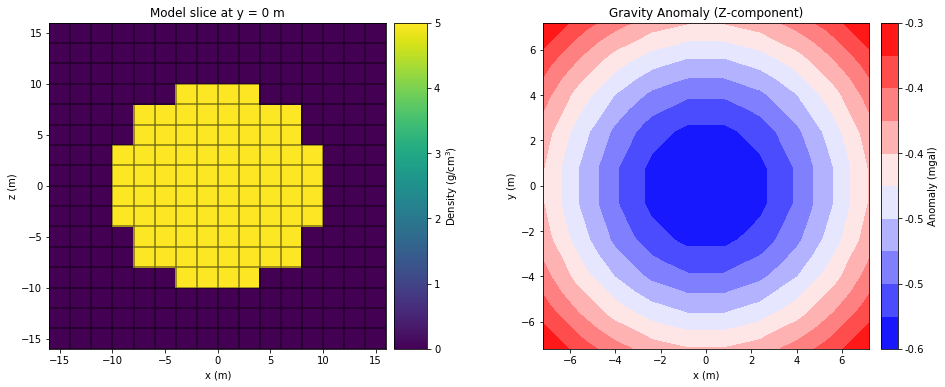

In [2]:
# Run the forward model for the true parameters
R_0 = 10
data = profile_timer(fwdmodel.calc_gravity, R_0, rho_0)
# These quick methods plot whatever gravity signal was last calculated
fig1 = plt.figure(figsize=(16,6))
ax1 = fig1.add_subplot(121)
fwdmodel.plot_model_slice(ax=ax1)
ax2 = fig1.add_subplot(122)
fwdmodel.plot_gravity(ax=ax2)
plt.show()

Although the discretized distribution produces a sphere-like gravity signal, it isn't quite a sphere:

fractional residuals mean, std = -0.00102 0.00791
log L difference (for obs noise of 10.0%) = 31.3


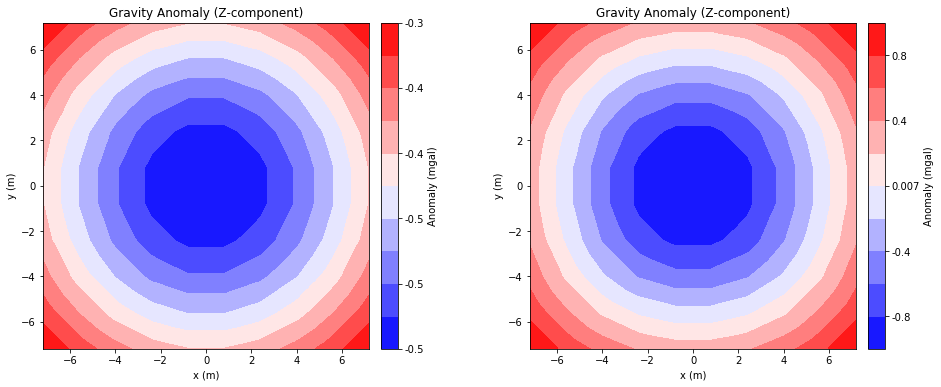

In [3]:
# Calculate analytic forward gravity and its residuals from the discretized version
data0 = analytic_forward_gravity_sphere(survey_10x10, R_0, rho_0, r0=(0,0,0))[2]
resids = data - data0
# In real applications will only be looking at anomaly -- mean signal will be subtracted off
resids -= resids.mean()
# Make measurement error a fraction of the full scale of the data, say 10%
sigrel = 0.1
sigdata = sigrel*np.std(data)
print("fractional residuals mean, std = {:.3g} {:.3g}".format((resids/data0).mean(), (resids/data0).std()))
print("log L difference (for obs noise of {:.1f}%) = {:.3g}".format(100*sigrel, np.sum((resids/sigdata)**2)))
# Plot the results
fig2 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
plot_gravity(survey_10x10, data0, ax=ax1)
ax2 = plt.subplot(122)
plot_gravity(survey_10x10, resids/sigdata, ax=ax2)
plt.show()

The inaccuracy may not look like much at first, but it amounts to 10% of the noise error, and spread over 100 points in the survey, this inaccuracy ends up taking its toll.  The good news is that, at least on the surface, the error in the data seems smooth and well-approximated by a smooth function like a Gaussian process.  We might therefore expect existing model calibration frameworks, such as Kennedy & O'Hagan (2001), to work reasonably well.

Just for fun, let's try a scan across the likelihood now, in the two variables $\rho$ and $R$; remember that we expect the mode to lie along $\frac{4}{3} \pi \rho R^3 = M$:

In [4]:
def log_likelihood(data, dpred, sigma):
    # Independent Gaussian for sake of argument
    resids = data - dpred
    resids -= resids.mean()
    return -0.5*np.sum(resids**2/sigma**2 + np.log(2*np.pi*sigma**2))

def run_grid(dsynth, rho_vals, R_vals, calc_gravity):
    grid_vals = [ ]
    for rho in rho_vals:
        for R in R_vals:
            dpred = calc_gravity(R, rho)
            grid_vals.append([rho, R, log_likelihood(dpred, dsynth, sigdata)])
    grid_vals = np.array(grid_vals).T.reshape(3, len(rho_vals), len(R_vals))
    return grid_vals

def show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0):
    levels = 10**np.arange(-6,0.1)
    levels = np.log(10)*np.arange(-6,0.1)
    # plt.contourf(xg, yg, np.exp(Lg - Lg.max()), levels=levels)
    plt.contourf(xg, yg, Lg - Lg.max(), levels=levels)
    plt.plot(rho_vals, R_vals, ls='--', lw=2, color='white')
    plt.plot(rho_0, R_0, marker='+', ms=15, mew=3, color='red')
    plt.colorbar()
    ax1.set_xlim(rho_vals.min(), rho_vals.max())
    ax1.set_ylim(R_vals.min(), R_vals.max())

run_grid ran in 1.152 sec
run_grid ran in 0.123 sec


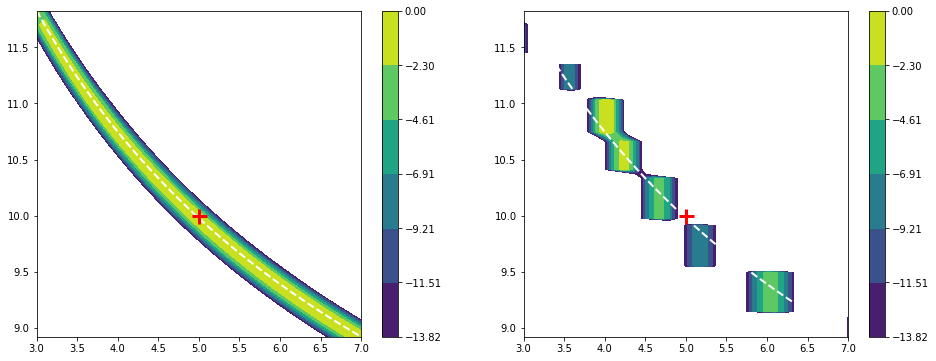

In [5]:
epsilon = sigdata*np.random.normal(size=data0.shape)
dsynth = data0 + epsilon

M = 4.0*np.pi/3.0 * rho_0 * R_0**3
rho2R = lambda rho: (0.75*M/(np.pi*rho_vals))**0.333

# Run the grid
rho_vals = np.arange(rho_0 - 2.0, rho_0 + 2.01, 0.1)
R_vals = rho2R(rho_vals)
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                           fwdmodel.calc_gravity)
xg, yg, Lg0 = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                            lambda R, rho: analytic_forward_gravity_sphere(fwdmodel.survey, R, rho, r0=(0,0,0))[2])

# Show two views, as in the other notebook
fig3 = plt.figure(figsize=(16,6))
# First, on left, is a contour plot of the analytic posterior
# Indicate the locus of equal mass for the sphere, and the true solution
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
# Second, on right, is a plot of the navigable area including the true value
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
# Show both plots
plt.show()

The posterior contours are drawn on a log scale, with a factor of 10 in probability density between each contour level, and the lowest level at a density of $10^{-6}$ relative to the mode.  This 

From this we can see that the discretization has separated the geological likelihood distribution into mutually disjoint islands, even though the underlying _true_ geological likelihood is smooth.  It isn't _just_ that discretization makes the difference, in theory, between running Hamiltonian Monte Carlo and running a vastly more computationally expensive parallel-tempered scheme.  The inference is also biased; the true values don't lie within the support of the discretized likelihood.  The full extent of the analytic likelihood is also not represented, so that the discretized calculation ends up artificially restricting the solution space relative to the full solution.

And yet _some_ kind of discretization is needed to proceed for problems with no analytic solution, so we'll need to understand how to quantify these effects.

So clearly we'll get a better approximation if we improve our resolution.  What does that cost us?

DiscreteGravity ran in 0.016 sec
calc_gravity ran in 1.501 sec


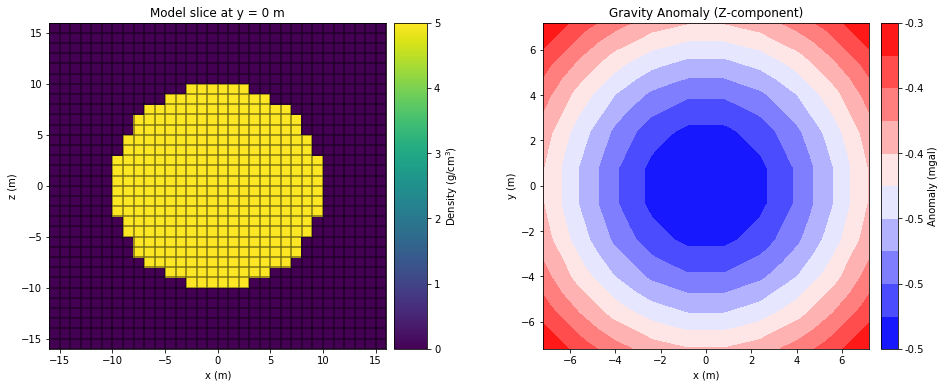

In [6]:
# Instantiate a finer mesh for the same survey
L, h = 16.0, 1.0
Nh = 2*int(L/h)
mesh = baseline_tensor_mesh(Nh, h)

# New forward model
fwdmodel2 = profile_timer(DiscreteGravity, mesh, survey_10x10, gfunc)
data2 = profile_timer(fwdmodel2.calc_gravity, R_0, rho_0)
fig4 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
fwdmodel2.plot_model_slice(ax=ax1)
ax2 = plt.subplot(122)
fwdmodel2.plot_gravity(ax=ax2)
plt.show()

That's better!  How does it perform?

run_grid ran in 6.423 sec


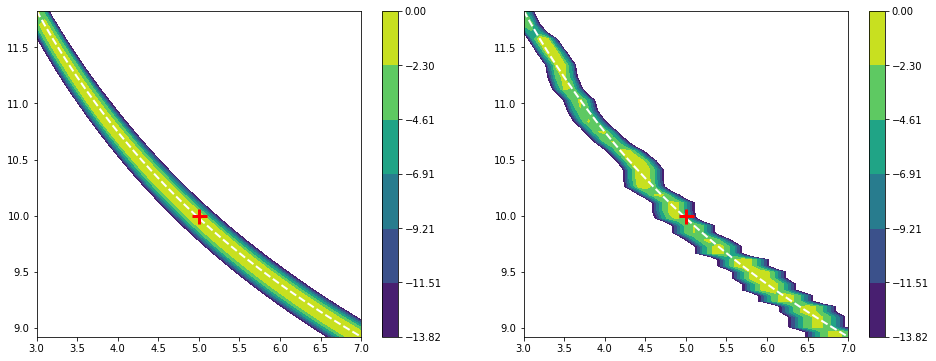

In [7]:
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel2.calc_gravity)
fig5 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

This starts to connect the modes up with each other.  Finer still?

DiscreteGravity ran in 0.122 sec
calc_gravity ran in 14.791 sec


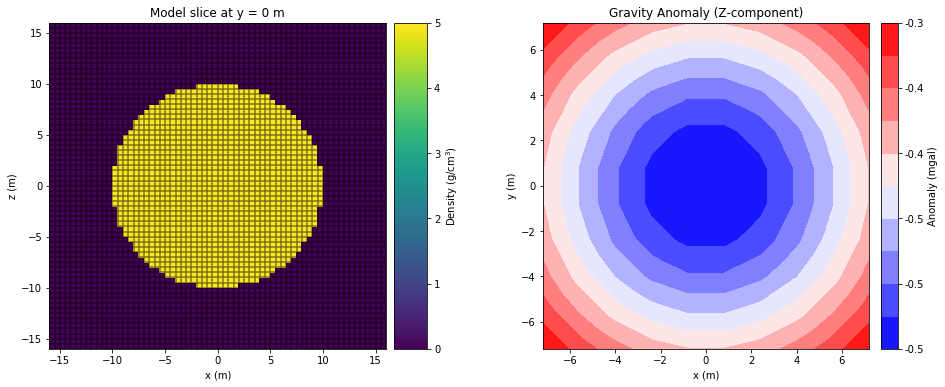

In [8]:
# Instantiate a finer mesh for the same survey
L, h = 16.0, 0.5
Nh = 2*int(L/h)
mesh = baseline_tensor_mesh(Nh, h)

# New forward model
fwdmodel3 = profile_timer(DiscreteGravity, mesh, survey_10x10, gfunc)
data3 = profile_timer(fwdmodel3.calc_gravity, R_0, rho_0)
fig6 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
fwdmodel3.plot_model_slice(ax=ax1)
ax2 = plt.subplot(122)
fwdmodel3.plot_gravity(ax=ax2)
plt.show()

run_grid ran in 50.300 sec


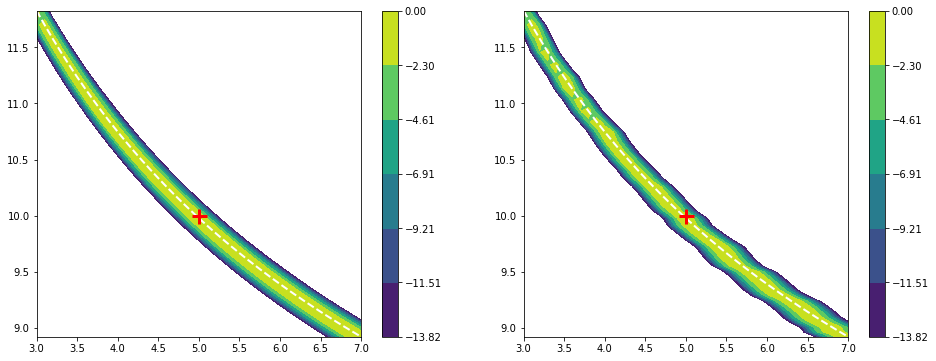

In [9]:
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel3.calc_gravity)
fig7 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

This is a much better approximation of the true posterior.  But it's worth noting the cost:  the discrete version runs about 400 times slower than the analytic version, even when the sensitivities are cached.

Perhaps unsurprisingly, the adequacy of the discrete likelihood approximation also depends on the properties of the dataset:  better data can resolve finer spatial detail, so that a discretization of an area adequate to do inference using one dataset may no longer work for another.  If we change the noise variance and recalculate, we get this:

calc_gravity ran in 0.005 sec
run_grid ran in 6.073 sec
run_grid ran in 0.133 sec


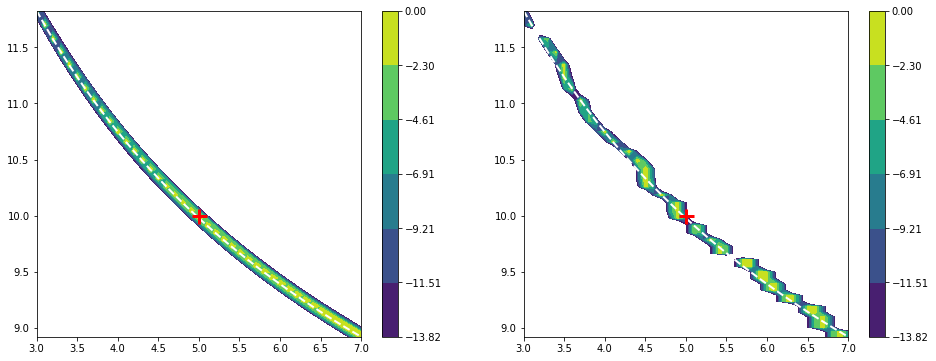

In [10]:
sigrel = 0.05
sigdata = sigrel*np.std(data0)
epsilon = sigdata*np.random.normal(size=dsynth.shape)
dsynth = data0 + epsilon

# New forward model
data4 = profile_timer(fwdmodel2.calc_gravity, R_0, rho_0)
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel2.calc_gravity)
xg, yg, Lg0 = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                            lambda R, rho: analytic_forward_gravity_sphere(fwdmodel.survey, R, rho, r0=(0,0,0))[2])
fig8 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

If we change the survey density (the number of data points), we get a slower calculation as as a less accurate likelihood:

DiscreteGravity ran in 0.059 sec
calc_gravity ran in 11.219 sec
run_grid ran in 26.778 sec
run_grid ran in 0.191 sec


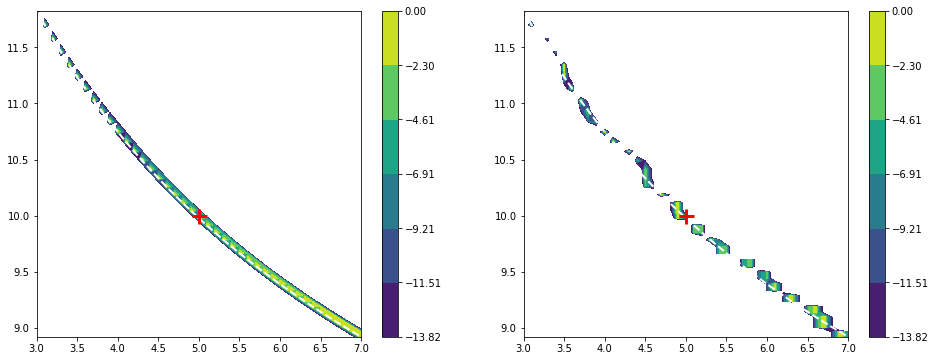

In [11]:
survey_30x30 = survey_gridded_locations(L, L, 30, 30, L, ['gz'])
data0 = analytic_forward_gravity_sphere(survey_30x30, R_0, rho_0, r0=(0,0,0))[2]
sigrel = 0.1
sigdata = sigrel*np.std(data0)
epsilon = sigdata*np.random.normal(size=data0.shape)
dsynth = data0 + epsilon

fwdmodel4 = profile_timer(DiscreteGravity, fwdmodel2.mesh, survey_30x30, gfunc)
data4 = profile_timer(fwdmodel4.calc_gravity, R_0, rho_0)
xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel4.calc_gravity)
xg, yg, Lg0 = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                            lambda R, rho: analytic_forward_gravity_sphere(fwdmodel4.survey, R, rho, r0=(0,0,0))[2])
fig9 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()

## Adaptive Meshes and Anti-Aliasing

(put some words here)

/Users/rscalzo/.conda/envs/gempy/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/rscalzo/.conda/envs/gempy/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


DiscreteGravity ran in 0.011 sec
calc_gravity ran in 0.656 sec


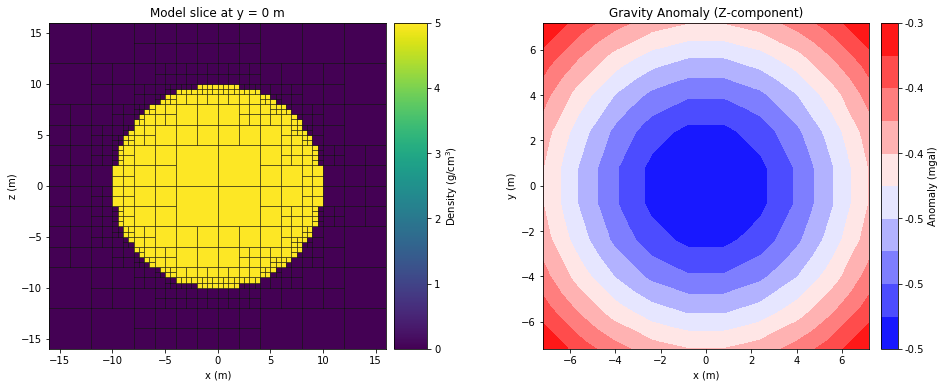

In [14]:
# Produce an octree mesh refined along the sphere border
import blockworlds
from blockworlds import baseline_octree_mesh, refine_octree_surface
L, h = 16.0, 0.5
Nh = 2*int(L/h)
mesh = baseline_octree_mesh(Nh, h)
f = lambda x, y: np.sqrt(R_0**2 - x**2 - y**2)
mesh = refine_octree_surface(mesh, f)
f = lambda x, y: -np.sqrt(R_0**2 - x**2 - y**2)
mesh = refine_octree_surface(mesh, f)
mesh.finalize()

# New forward model
fwdmodel5 = profile_timer(DiscreteGravity, mesh, survey_10x10, gfunc)
data4 = profile_timer(fwdmodel5.calc_gravity, R_0, rho_0)
fig8 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
fwdmodel5.plot_model_slice(ax=ax1)
ax2 = plt.subplot(122)
fwdmodel5.plot_gravity(ax=ax2)
plt.show()

run_grid ran in 3.532 sec
run_grid ran in 0.146 sec


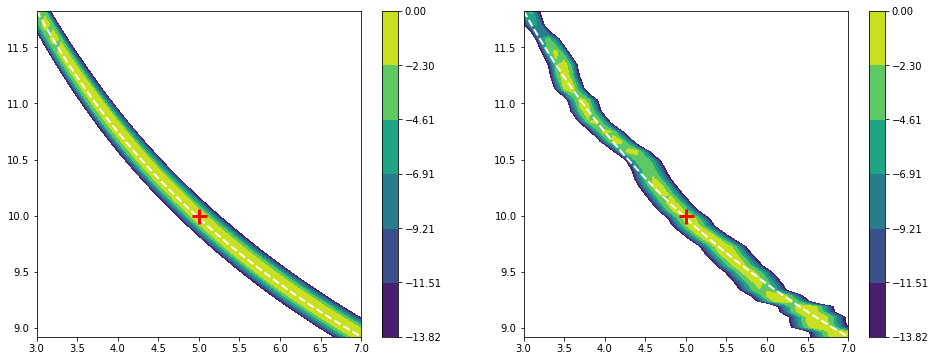

In [18]:
data0 = analytic_forward_gravity_sphere(survey_10x10, R_0, rho_0, r0=(0,0,0))[2]
sigrel = 0.1
sigdata = sigrel*np.std(data0)
epsilon = sigdata*np.random.normal(size=data0.shape)
dsynth = data0 + epsilon

xg, yg, Lg = profile_timer(run_grid, dsynth, rho_vals, R_vals, fwdmodel5.calc_gravity)
xg, yg, Lg0 = profile_timer(run_grid, dsynth, rho_vals, R_vals,
                            lambda R, rho: analytic_forward_gravity_sphere(fwdmodel5.survey, R, rho, r0=(0,0,0))[2])
fig10 = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
show_contours(xg, yg, Lg0, rho_vals, R_vals, rho_0, R_0)
ax2 = plt.subplot(122)
show_contours(xg, yg, Lg, rho_vals, R_vals, rho_0, R_0)
plt.show()